# Mecab  Download

In [1]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 


Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 3.70 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [2]:
cd Mecab-ko-for-Google-Colab


/content/Mecab-ko-for-Google-Colab


In [3]:
!bash install_mecab-ko_on_colab_light_220429.sh

Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-05-03 13:33:18--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=

# Library import

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/hate_discrimination_nlp

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/hate_discrimination_nlp


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, f1_score

import torch.nn as nn
import torch.optim as optim

from collections import Counter
from tqdm import tqdm

# Data 가져오기, data 확인

In [6]:
df = pd.read_csv('./train.csv', encoding='utf-8')
df

,ID,text,label
0,0,유소영비호감 성형아줌마,1
1,1,나오지마라 썅,3
2,2,식상하고 지긋지긋했는데 잘 끝나네 오예 소리벗고 빤스질러~~!!!,6
3,3,성희롱 당할 얼굴이 아닌데?ㅋㅋㅋ,5
4,4,"""끝까지 해보자~쪽파리 원숭이 자한 쓰레기당""",0
...,...,...,...
65858,65858,ㅋ ㅋ 쇼~~~ 도 적당히,6
65859,65859,"""이젠 전라도 종것들 음식 불매다. 태양광 중금속 환경오염물로 만든 식품 사절이다""",0
65860,65860,조센징들은 참 피곤하게 산다,0
65861,65861,"""문빠 다모아서 빨갱이한테보내고 행복하게살라고""",2


### class distribution

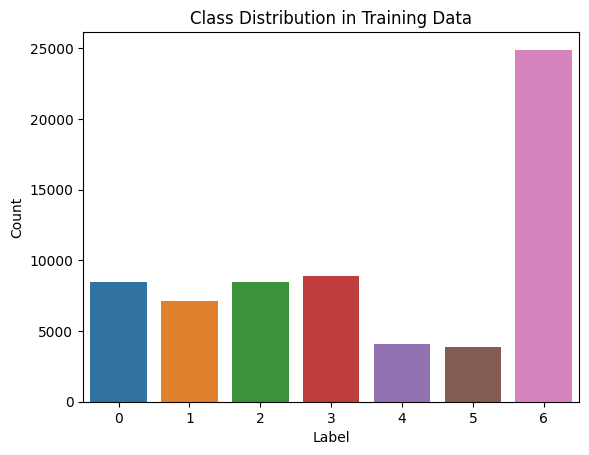

In [ ]:

# Plot the class distribution
sns.countplot(x='label', data=df)

# Add labels to the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')

# Show the plot
plt.show()

In [ ]:
df['label'].value_counts()

6    24900
3     8895
2     8481
0     8463
1     7107
4     4118
5     3899
Name: label, dtype: int64

### Get the length of each sentence

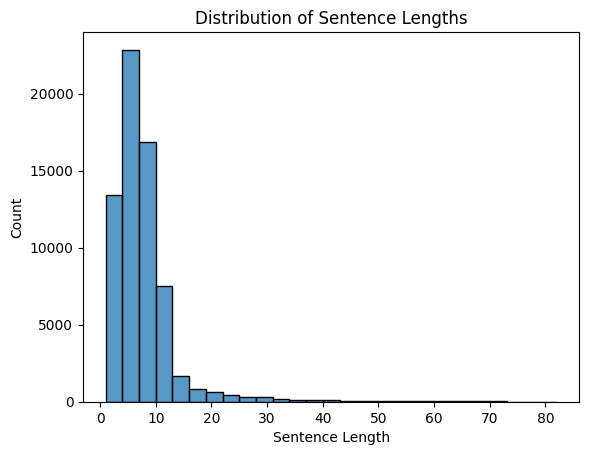

In [ ]:
# Get the length of each sentence
sentence_lengths = df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
sns.histplot(data=sentence_lengths, binwidth=3)

# Add labels to the plot
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths')

# Show the plot
plt.show()

# Tokenization, Data Processing 

In [7]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [24]:

def preprocess(df):
  
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글 공백제외 모두제거
  df['text'] = df['text'].str.replace('^ +', "")  # 공백은 empty 값으로 변경
  df['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
  df = df.dropna(how='any') #Null 값 제거 
  
  # Tokenize
  Me = Mecab()
  # 불용어 설정
  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

  X = []
  for sentence in tqdm(df['text']):
    tokenized_sentence = Me.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X.append(stopwords_removed_sentence)

  X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)
  y_train = y_train.reset_index(drop=True)
  y_test = y_test.reset_index(drop=True)
  return X_train, X_test, y_train, y_test

X_train, X_val, y_train, y_val = preprocess(df)



<ipython-input-24-274c5e592db8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글 공백제외 모두제거
<ipython-input-24-274c5e592db8>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('^ +', "")  # 공백은 empty 값으로 변경
100%|██████████| 65800/65800 [00:05<00:00, 11797.07it/s]


In [25]:
# For Explanation
X_train[:5]

[['못생긴', '얼굴', '만큼', '못', '땐', '짖', '대단', '해'],
 ['애비', '왜', '다', '모양', '냐', '예은', '무슨', '죄', '냐', 'ㅅ', 'ㅂ'],
 ['종북', '인', '문재인', '한테', '오', '면', '북', '에서', '북', '오', '격'],
 ['이것', '조옷', '밥', '네', '뭐', '라도', '된', '거', '처럼'],
 ['못',
  '생겼',
  '어',
  '못',
  '돼',
  '보이',
  '고',
  '이시언',
  '에게',
  '야라',
  '반말',
  '하',
  '고',
  '인성',
  '별로',
  '임',
  '전현무',
  '만나',
  '서',
  '이미지',
  '세탁',
  '됐',
  '지']]

In [26]:
# Text Encoder 단어 -> 정수 로 바꿔주는 Class
class TextEncoder:
    def __init__(self, X):
        self.word_freq = None # 단어 빈도 수
        self.vocab = None # 단어 집합
        self.word_to_idx = None 
        self.vocab_size = None  # 단어 수
        self.rare_word_ratio = None
        self.count_word_freq(X) # 초기화 때 셈
        self.X = X
    def count_word_freq(self, X):
        # Count the frequency of each word in the text corpus
        self.word_freq = Counter(word for sample in X for word in sample)
    
    def create_vocab(self, threshold):
        # Create a vocabulary of unique words based on their frequency in the text corpus
        self.vocab = sorted(self.word_freq, key=self.word_freq.get, reverse=True)
        self.vocab = [word for word in self.vocab if self.word_freq[word] >= threshold]
        self.word_to_idx = {word: i+1 for i, word in enumerate(self.vocab)}  # start from 1 to reserve 0 for padding
    
    def integer_encode(self, X):
        # Convert each text sample to a sequence of integer indices using the vocabulary
        X_encoded = [[self.word_to_idx.get(word, 0) for word in sample] for sample in X]  
                                    ## threshold 보다 낮은 단어 삭제 하지 않고 0으로 대체
        return X_encoded
    
    def fit_transform(self, threshold, vocab_size):
        self.create_vocab(threshold)
        self.vocab_size = min(vocab_size, len(self.vocab)) if vocab_size is not None else len(self.vocab)
        self.word_to_idx = {word: i+1 for i, word in enumerate(self.vocab[:self.vocab_size])}  # start from 1 to reserve 0 for padding
        X_encoded = self.integer_encode(self.X)
        return X_encoded
    
    def vocab_ratio(self, threshold):
        # Compute the ratio of rare words in the vocabulary
        total_cnt = len(self.word_freq)
        rare_cnt = sum(1 for freq in self.word_freq.values() if freq < threshold)
        rare_word_ratio = rare_cnt / total_cnt * 100
        total_freq = 0
        rare_freq = 0

        for key, value in self.word_freq.items():
            total_freq += value
            if value < threshold:
                rare_freq += value
        # Print the ratio
        print('Size of the Vocabulary set: {}'.format(total_cnt))
        print('Rare words that apper less than {0} times : {1}'.format(threshold, rare_cnt))
        print('Ratio of rare words in the vocab set: {:.4f}'.format(rare_word_ratio))
        print("Ratio of rare words based on total apperance:", (rare_freq / total_freq)*100)
        print("Size of vocab if using this threshold: ", total_cnt - rare_cnt + 1)

In [27]:
encoder = TextEncoder(X_train)
encoder.vocab_ratio(3)

Size of the Vocabulary set: 33716
Rare words that apper less than 3 times : 20214
Ratio of rare words in the vocab set: 59.9537
Ratio of rare words based on total apperance: 3.486928186280638
Size of vocab if using this threshold:  13503


In [29]:
X_train = encoder.fit_transform(3, 13503) # 직접 만든 클래스라 출력 결과 보고 넣어줘야 됨.. 이게 맞나...
X_val = encoder.integer_encode(X_val)

In [30]:
X_train[:5]

[[294, 55, 694, 39, 1033, 1661, 480, 40],
 [1125, 32, 3, 1298, 12, 9285, 168, 373, 12, 87, 123],
 [879, 43, 126, 78, 179, 13, 441, 46, 441, 179, 3189],
 [848, 4707, 431, 4, 50, 154, 230, 8, 146],
 [39,
  122,
  19,
  39,
  282,
  214,
  2,
  2489,
  241,
  0,
  4243,
  1,
  2,
  671,
  628,
  112,
  1114,
  311,
  56,
  689,
  3190,
  315,
  5]]

리뷰의 최대 길이 : 138
리뷰의 평균 길이 : 13.676785714285714


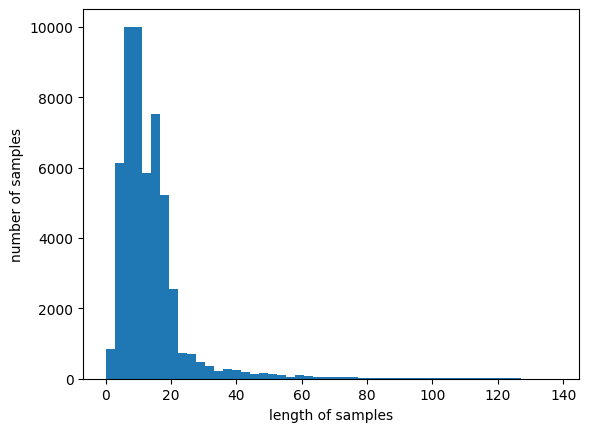

In [31]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.9411094224924


In [37]:
# SequencePadder 각 샘플 길이 일정 길이로 통일 기준보다 짧은 경우 0으로 채움
class SequencePadder:
    def __init__(self, max_len):
        self.max_len = max_len

    def fit_transform(self, sequences):
        """
        Pad sequences to a maximum length and return the resulting array.
        """
        padded_sequences = np.zeros((len(sequences), self.max_len))
        for i, seq in enumerate(sequences):
            if len(seq) > self.max_len:
                padded_sequences[i, :] = seq[:self.max_len]
            else:
                padded_sequences[i, :len(seq)] = seq
        return padded_sequences
pad_sequence = SequencePadder(30)


In [38]:
X_train = pad_sequence.fit_transform(X_train)
X_val = pad_sequence.fit_transform(X_val)

In [42]:
X_train[:5]

array([[ 294.,   55.,  694.,   39., 1033., 1661.,  480.,   40.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [1125.,   32.,    3., 1298.,   12., 9285.,  168.,  373.,   12.,
          87.,  123.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [ 879.,   43.,  126.,   78.,  179.,   13.,  441.,   46.,  441.,
         179., 3189.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [ 848., 4707.,  431.,    4.,   50.,  154.,  230.,    8.,  146.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [  39.,  122.,   19.,

# dataset, dataloader 준비

In [43]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        X = torch.tensor(X, dtype=torch.int64)
        y = torch.tensor(y, dtype=torch.int64)
        return X, y

# Create train and validation datasets
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

# train_dataset = TextDataset(X_train.toarray(), df_train['label'].values)
# val_dataset = TextDataset(X_val.toarray(), df_val['label'].values)

# Create train and validation data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)

In [44]:
train_dataset[0]

(tensor([ 294,   55,  694,   39, 1033, 1661,  480,   40,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor(1))

# Model Training

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        output = self.fc(hidden)
        return output

# Set hyperparameters
vocab_size = int(X_train.max() + 1)
embedding_dim = 128
hidden_dim = 256
output_dim = 7
num_layers = 2
dropout = 0.5
lr = 1e-3
num_epochs = 20

# Instantiate the LSTM model
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_f1 = 0.0
    valid_loss = 0.0
    valid_f1 = 0.0
    
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_f1 += f1_score(labels.cpu(), outputs.argmax(dim=1).cpu(), average='weighted')
    train_loss /= len(train_loader)
    train_f1 /= len(train_loader)

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            valid_f1 += f1_score(labels.cpu(), outputs.argmax(dim=1).cpu(), average='weighted')
        valid_loss /= len(valid_loader)
        valid_f1 /= len(valid_loader)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train F1={train_f1:.4f}, Val Loss={valid_loss:.4f}, Val F1={valid_f1:.4f}')


Epoch 1/20: Train Loss=1.6842, Train F1=0.2480, Val Loss=1.4617, Val F1=0.3676
Epoch 2/20: Train Loss=1.3662, Train F1=0.4628, Val Loss=1.1145, Val F1=0.6061
Epoch 3/20: Train Loss=1.1059, Train F1=0.6195, Val Loss=0.9306, Val F1=0.6914
Epoch 4/20: Train Loss=0.9680, Train F1=0.6732, Val Loss=0.8551, Val F1=0.7129
Epoch 5/20: Train Loss=0.8886, Train F1=0.6995, Val Loss=0.7902, Val F1=0.7364
Epoch 6/20: Train Loss=0.8335, Train F1=0.7165, Val Loss=0.7605, Val F1=0.7420
Epoch 7/20: Train Loss=0.7869, Train F1=0.7327, Val Loss=0.7548, Val F1=0.7479
Epoch 8/20: Train Loss=0.7572, Train F1=0.7434, Val Loss=0.7203, Val F1=0.7560
Epoch 9/20: Train Loss=0.7258, Train F1=0.7541, Val Loss=0.7178, Val F1=0.7540
Epoch 10/20: Train Loss=0.7017, Train F1=0.7612, Val Loss=0.7123, Val F1=0.7583
Epoch 11/20: Train Loss=0.6808, Train F1=0.7676, Val Loss=0.7102, Val F1=0.7607
Epoch 12/20: Train Loss=0.6610, Train F1=0.7737, Val Loss=0.7037, Val F1=0.7616
Epoch 13/20: Train Loss=0.6432, Train F1=0.7808, 

# 제출

In [ ]:
df_test = pd.read_csv('./test.csv', encoding='utf-8')

In [ ]:
def preprocess_test(df):
  
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
  df['text'] = df['text'].str.replace('^ +', "")  
  df['text'].replace('', np.nan, inplace=True) 
  df_test['text'] = df_test['text'].astype(str)

  # Tokenize
  Me = Mecab()

  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

  X = []
  for sentence in tqdm(df['text']):
    tokenized_sentence = Me.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X.append(stopwords_removed_sentence)
  return X

X_test = preprocess_test(df_test)
X_test = encoder.integer_encode(X_test) # caution: 위에서 train data로 만든 encoder 사용
X_test = pad_sequence.fit_transform(X_test)


class TestDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X = self.X[idx]
        X = torch.tensor(X, dtype=torch.int64)#.to(device)
        return X
test_set = TestDataset(X_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


<ipython-input-208-1f8090e93723>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글 공백제외 모두제거
<ipython-input-208-1f8090e93723>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('^ +', "")  # 공백은 empty 값으로 변경
100%|██████████| 13491/13491 [00:01<00:00, 11403.10it/s]


In [ ]:
X_test[0]

array([3.620e+02, 1.350e+02, 5.800e+01, 2.181e+03, 4.160e+02, 1.000e+00,
       2.000e+00, 6.990e+02, 4.160e+02, 1.000e+00, 2.000e+00, 3.830e+02,
       4.160e+02, 1.000e+00, 3.000e+00, 5.800e+01, 1.200e+02, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [ ]:
# Switch model to evaluation mode
model.eval()

# Create empty list to store predictions
all_preds = []

# Move model to device
model.to(device)

# Iterate over test data
with torch.no_grad():
    for inputs in test_loader:
        # Move inputs to device
        inputs = inputs.to(device)

        # Forward pass to get outputs
        outputs = model(inputs)

        # Get predicted class for each example
        _, predicted = torch.max(outputs.data, 1)

        # Append predicted class to all_preds list
        all_preds.extend(predicted.cpu().numpy())


In [ ]:
df_test['label'] = all_preds

In [ ]:
df_test

,ID,text,label
0,0,솔직히 우리나라 청년들도 불쌍하고 아재들도 불쌍하고 노인들도 불쌍하다 나라가 참,6
1,1,그만 보고싶네요 늙은애들은,4
2,2,더러운 개신교벌레 새퀴,3
3,3,근데전태수씨 사망이유가뭔가요그어떤기사에도 나오질않네요,6
4,4,태극기부대와 틀닭바퀴충들에게 순시리는 국모다 ㅉㅉ,2
...,...,...,...
13486,13486,ㅅㅂ저년 한국인 아니라서 법적으로 어떻게 못하는거아님아 ㅅㅂ 느그나라로 꺼져,3
13487,13487,틀딱 택시기사 왔는가,4
13488,13488,틀딱들의 흔한 망상중 하나죠ㅋㅋ,4
13489,13489,빨갱이 새끼 역시 잔인하노 능지처참은 중국놈인 니놈이고,2


In [ ]:
df_sub = df_test.drop('text', axis=1)

In [ ]:
df_sub.to_csv('./submission5.csv', index=False)


In [ ]:
df_sub

,ID,label
0,0,1
1,1,3
2,2,6
3,3,5
4,4,0
...,...,...
65858,65858,6
65859,65859,0
65860,65860,0
65861,65861,2
